# Stochastic Gradient Descent


Converged after 0 iterations
Gradient Descent (α=0.05, noisy)
    Starting point: [3. 0.]
    Final point [3. 0.]
    Function value: 9.0000
    Distance from true minimum (0,0): 3.000


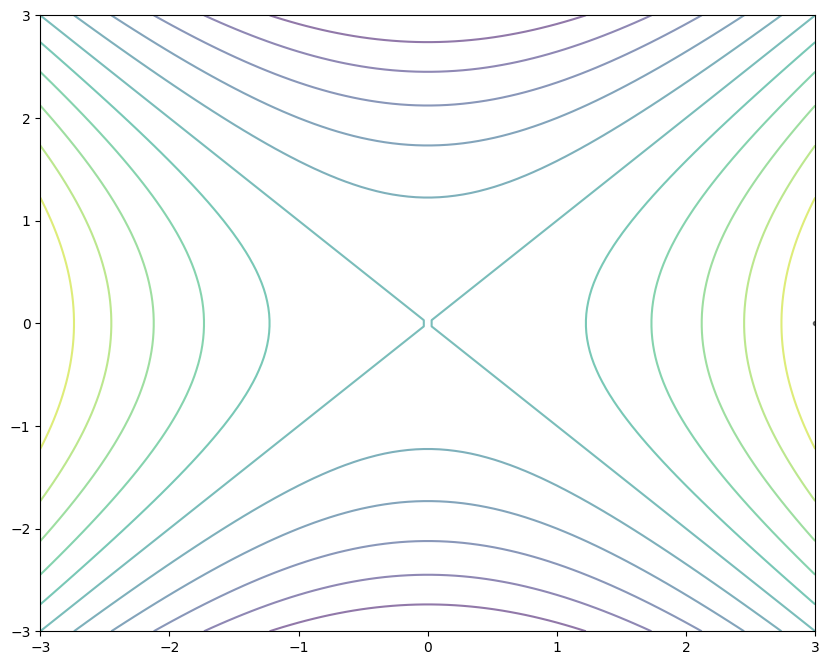

In [ ]:
from abc import ABC, abstractmethod
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax
import numpy as np

class DescentMethod(ABC):
    @abstractmethod
    def init(self, f, grad_f, x0):
        pass
    
    @abstractmethod
    def step(self, f, grad_f, x):
        pass

def iterated_descent(method: DescentMethod,
                     f, 
                     grad_f, 
                     x0,
                     tol=1e-5,
                     k_max=1000):
    method.init(f, grad_f, x0)
    x = x0
    history = [x.copy()]
    for i in range(k_max):
        x_new = method.step(f, grad_f, x)
        if jnp.linalg.norm(x_new - x) < tol:
            print(f"Converged after {i} iterations")
            break
        x = x_new
        history.append(x)
    return x, jnp.array(history)

class NoisyDescent(DescentMethod):
    def __init__(self, submethod, sigma, key):
        self.submethod = submethod
        self.sigma = sigma
        self.key = key  
        self.k = 0          

    def init(self, f, grad_f, x):
        self.submethod.init(f, grad_f, x)
        self.k = 0
        return self

    def step(self, f, grad_f, x):
        x = self.submethod.step(f, grad_f, x)
        sigma = self.sigma[self.k % len(self.sigma)]  # safe indexing
        self.key, subkey = jax.random.split(self.key)
        noise = sigma * jax.random.normal(subkey, shape=x.shape)
        x = x + noise
        self.k += 1
        return x

class GradientDescent(DescentMethod):
    def __init__(self, alpha=0.01):
        self.alpha = alpha
        
    def init(self, f, grad_f, x0):
        return self
    
    def step(self, f, grad_f, x):
        return x - self.alpha * grad_f(x)

def func(x):
    return x[0]**2 - x[1]**2

def grad_f(x):
    return jax.grad(func)(x)

def run_optim(method, f, grad_f, x0, k_max, method_name):
    result, history = iterated_descent(method, f, grad_f, x0, k_max)
    print(f'{method_name}')
    print(f'    Starting point: {x0}')
    print(f'    Final point {result}')
    print(f'    Function value: {f(result):.4f}')
    print(f'    Distance from critical point (0,0): {np.linalg.norm(result - jnp.array([0.0, 0.0])):.3f}')
    return result, history


key = jax.random.key(17)
n_iters = 300
step_size = 0.05

additive_noise = 0.1 / (1 + jnp.arange(n_iters))

x0 = jnp.array([3.0, 0.0])

g_noisy = NoisyDescent(
    GradientDescent(alpha=step_size),
    sigma=additive_noise,
    key=key
)

result, path = run_optim(g_noisy, func, grad_f,
                         x0, 1000, f"Gradient Descent (α={step_size}, noisy)")


path = np.array(path)

plt.figure(figsize=(10,8))
x_range = np.linspace(-3, 3, 100)
y_range = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x_range, y_range)
Z = X**2 - Y**2
# --- countor plot (isovalues) ---
plt.contour(X, Y, Z, levels=15, alpha=0.6)
plt.plot(path[:,0], path[:,1], '.-', color='black', alpha=0.5,
         label='Gradient Descent Path') # optimization history
plt.show()


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Gradient Descent (α=0.1, noisy σₖ=0.1/(1+k))
    Starting point: [3.  0.5]
    Final point:    [6.0275581e-04 2.6069034e+23]
    Function value: -inf
    Distance from minimum (0,0): inf


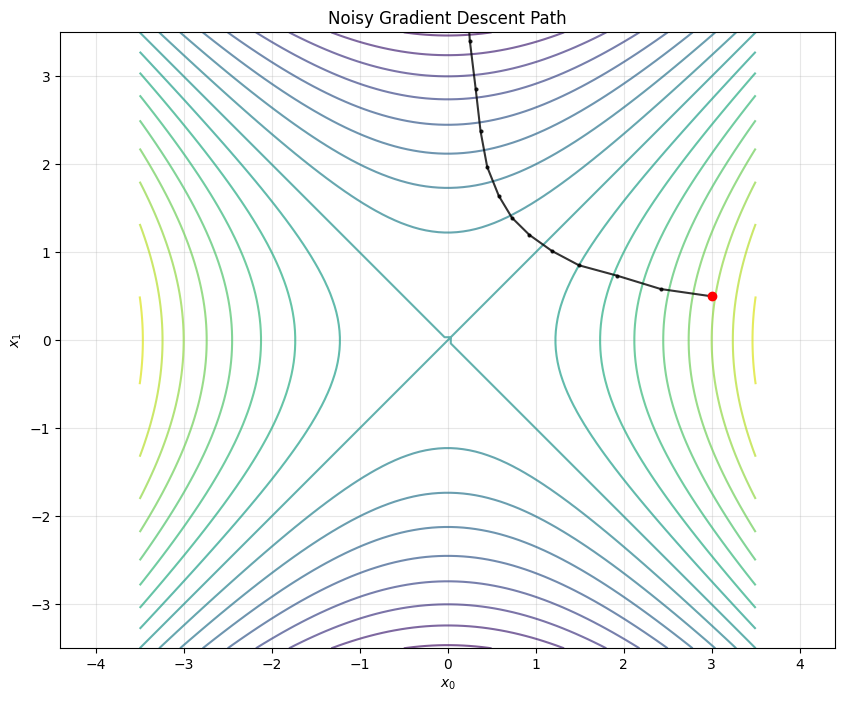

In [ ]:
from abc import ABC, abstractmethod
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

class DescentMethod(ABC):
    @abstractmethod
    def init(self, x, key):
        """Initialize method state given starting point and PRNG key."""
        pass

    @abstractmethod
    def step(self, f, grad_f, x, state):
        """Compute next x and updated state."""
        pass

class GradientDescent(DescentMethod):
    def __init__(self, alpha=0.01):
        self.alpha = alpha

    def init(self, x, key):
        return {}  

    def step(self, f, grad_f, x, state):
        x_new = x - self.alpha * grad_f(x)
        return x_new, state


class NoisyDescent(DescentMethod):
    def __init__(self, submethod, sigma_schedule):
        self.submethod = submethod
        self.sigma_schedule = sigma_schedule  

    def init(self, x, key):
        subkey1, subkey2 = jax.random.split(key)
        sub_state = self.submethod.init(x, subkey1)
        return {
            'sub_state': sub_state,
            'step': 0,
            'key': subkey2
        }

    def step(self, f, grad_f, x, state):
        # Step 1: Submethod update
        x_new, sub_state_new = self.submethod.step(f, grad_f, x, state['sub_state'])

        # Step 2: Add noise
        k = state['step']
        sigma = self.sigma_schedule(k)
        key = state['key']
        noise_key, next_key = jax.random.split(key)
        noise = sigma * jax.random.normal(noise_key, shape=x.shape)
        x_noisy = x_new + noise

        # Update state
        new_state = {
            'sub_state': sub_state_new,
            'step': k + 1,
            'key': next_key
        }
        return x_noisy, new_state


def iterated_descent(method: DescentMethod,
                     f,
                     grad_f,
                     x0,
                     key,
                     tol=1e-5,
                     k_max=1000):
    state = method.init(x0, key)
    x = x0
    history = [x]

    for i in range(k_max):
        x_new, state = method.step(f, grad_f, x, state)
        if jnp.linalg.norm(x_new - x) < tol:
            print(f"Converged after {i+1} iterations")
            break
        x = x_new
        history.append(x)

    return x, jnp.array(history)


def func(x):
    return x[0]**2 - x[1]**2  

def grad_f(x):
    return jax.grad(func)(x)

def run_optim(method, f, grad_f, x0, key, k_max, method_name):
    result, history = iterated_descent(method, f, grad_f, x0, key, k_max=k_max)
    print(f'{method_name}')
    print(f'    Starting point: {x0}')
    print(f'    Final point:    {result}')
    print(f'    Function value: {f(result):.6f}')
    print(f'    Distance from minimum (0,0): {jnp.linalg.norm(result):.6f}')
    return result, np.array(history)


key = jax.random.key(17)
x0 = jnp.array([3.0, 0.5])  # arbitrary start
step_size = 0.1
k_max = 300

sigma_schedule = lambda k: 0.1 / (1 + k)

gd = GradientDescent(alpha=step_size)
g_noisy = NoisyDescent(submethod=gd, sigma_schedule=sigma_schedule)

result, path = run_optim(
    g_noisy, func, grad_f, x0, key, k_max,
    f"Gradient Descent (α={step_size}, noisy σₖ=0.1/(1+k))"
)

plt.figure(figsize=(10, 8))
x_range = np.linspace(-3.5, 3.5, 100)
y_range = np.linspace(-3.5, 3.5, 100)
X, Y = np.meshgrid(x_range, y_range)
Z = X**2 - Y**2

plt.contour(X, Y, Z, levels=20, alpha=0.7, cmap='viridis')

plt.plot(path[:, 0], path[:, 1], '.-', color='black', alpha=0.8,
         label='Optimization Path', markersize=4)
plt.plot(path[0, 0], path[0, 1], 'ro', label='Start')
plt.plot(path[-1, 0], path[-1, 1], 'go', label='End')
plt.title('Noisy Gradient Descent Path')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.axis('equal')
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)
plt.show()